## Sign Language Detection

#### Import Libraries

In [3]:
import os
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Directories for data

In [2]:
IMAGE_TRAIN_DIR = '../data/images/train/'
IMAGE_VALIDATION_DIR = '../data/images/validation/'
VIDEO_TRAIN_DIR = '../data/videos/train/'
VIDEO_VAL_DIR = '../data/videos/validation/'
VIDEO_KATA_TRAIN_DIR = '../data/videos_kata/train/'
VIDEO_KATA_VAL_DIR = '../data/videos_kata/validation/'

#### Initialize MediaPipe

In [ ]:
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose

#### Preprocessing Function

In [4]:
def preprocess_image(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, [28, 28])
    image = image / 255.0
    return image

In [5]:
def preprocess_video(video_path, frame_size=(28, 28), max_frames=30):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = preprocess_image(frame)  # Resize and normalize the frame
        frames.append(frame)
    cap.release()

    # Truncate or pad the sequence to the desired length
    if len(frames) > max_frames:
        frames = frames[:max_frames]
    elif len(frames) < max_frames:
        frames = frames + [frames[-1]] * (max_frames - len(frames))  # Padding with last frame

    return np.array(frames)

#### Plotting example images

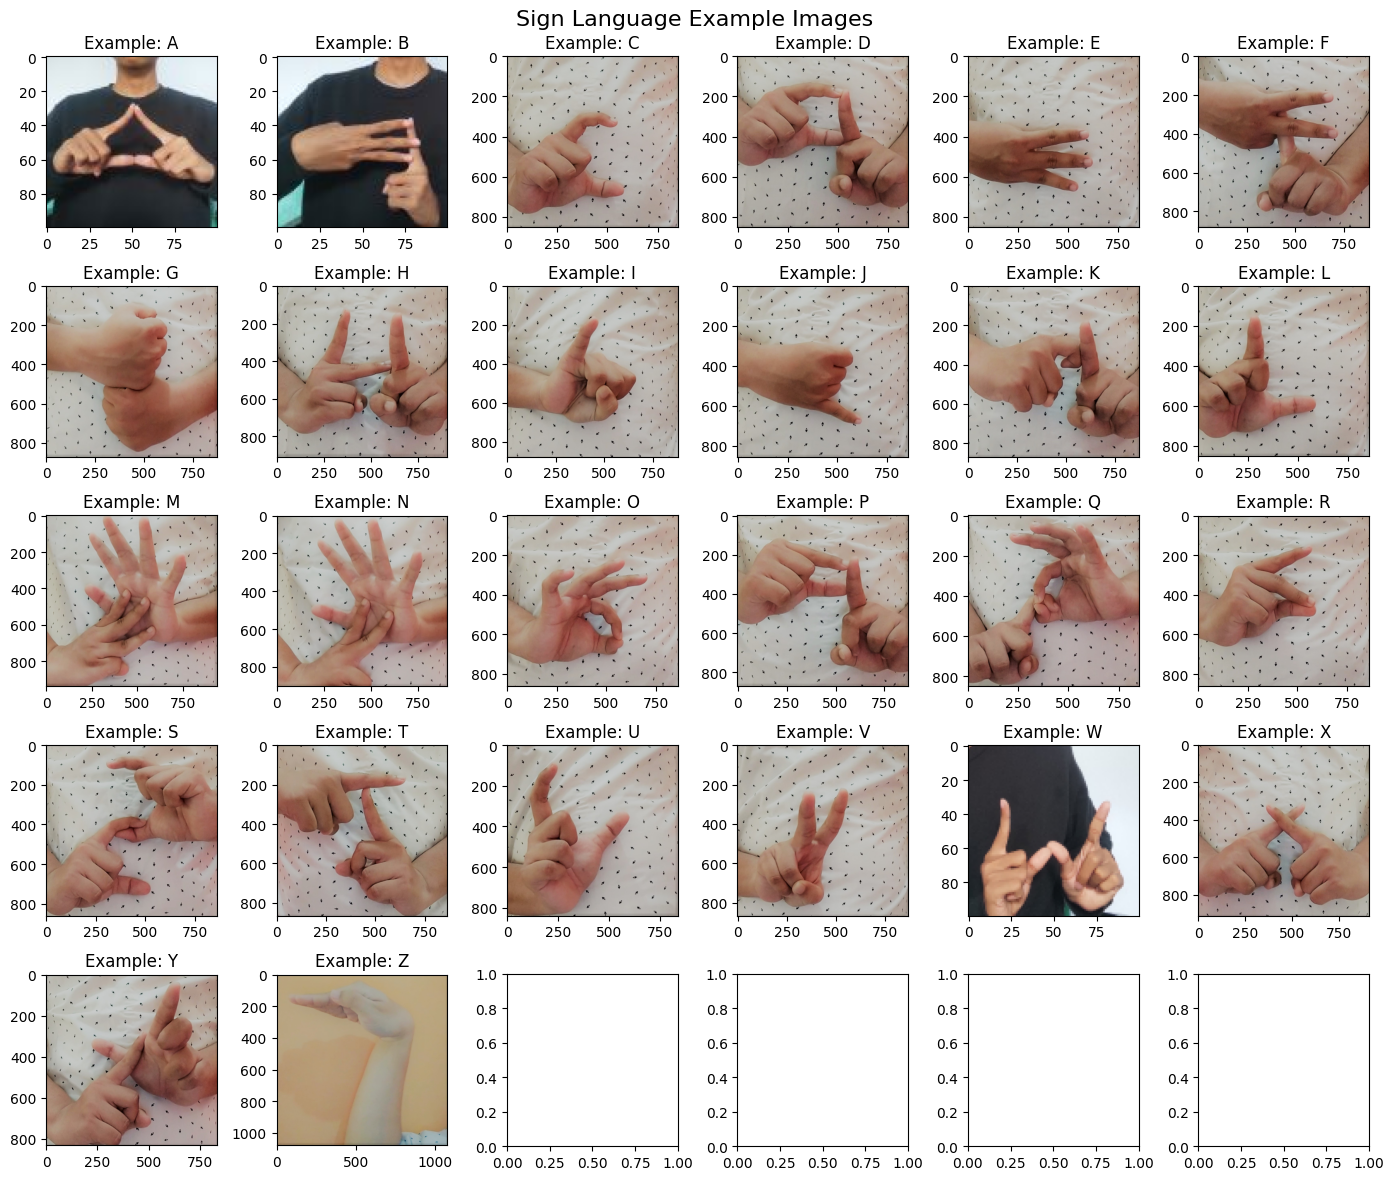

In [7]:
# Daftar huruf
letters = ['A', 'B', 'C', 'D', 'E', 'F',
           'G', 'H', 'I', 'J', 'K', 'L',
           'M', 'N', 'O', 'P', 'Q', 'R',
           'S', 'T', 'U', 'V', 'W', 'X',
           'Y', 'Z']

# Plot gambar contoh
rows = 5
cols = 6
fig, axes = plt.subplots(rows, cols, figsize=(14, 12))
axes = axes.flatten()
fig.suptitle('Sign Language Example Images', fontsize=16)

for i, letter in enumerate(letters):
    if i >= len(axes):
        break

    letter_dir = os.path.join(IMAGE_TRAIN_DIR, letter)
    try:
        img_path = [os.path.join(letter_dir, fname)
                    for fname in os.listdir(letter_dir)
                    if fname.endswith(('.jpg', '.png'))][0]

        img = tf.keras.preprocessing.image.load_img(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'Example: {letter}')
        axes[i].axis('on')

    except (FileNotFoundError, IndexError):
        axes[i].axis('on')
        axes[i].set_title(f'Missing: {letter}')

plt.tight_layout()
plt.show()

### Convert image to numpy array

In [8]:
# Konversi gambar ke array numpy
sample_array = tf.keras.preprocessing.image.img_to_array(img)
print(f"Each image has shape: {sample_array.shape}")
print(sample_array[0, :5])

Each image has shape: (1079, 1079, 3)
[[157. 138. 108.]
 [158. 139. 109.]
 [158. 139. 109.]
 [159. 140. 110.]
 [160. 141. 111.]]


### Create the dataset, training and validation

In [27]:
def train_val_datasets():
    #Dataset gambar
    train_dataset = image_dataset_from_directory(
        directory=IMAGE_TRAIN_DIR,
        batch_size=32,
        image_size=(28, 28),
        label_mode='categorical',
        color_mode='grayscale'
    )

    validation_dataset = image_dataset_from_directory(
        directory=IMAGE_VALIDATION_DIR,
        batch_size=32,
        image_size=(28, 28),
        label_mode='categorical',
        color_mode='grayscale'
    )

    return train_dataset, validation_dataset

### Create train and validation datasets

In [28]:
train_dataset, validation_dataset = train_val_datasets()
print(f"Images of train dataset have shape: {train_dataset.element_spec[0].shape}")
print(f"Labels of train dataset have shape: {train_dataset.element_spec[1].shape}")
print(f"Images of validation dataset have shape: {validation_dataset.element_spec[0].shape}")
print(f"Labels of validation dataset have shape: {validation_dataset.element_spec[1].shape}")

Found 2851 files belonging to 26 classes.
Found 2851 files belonging to 26 classes.
Images of train dataset have shape: (None, 28, 28, 1)
Labels of train dataset have shape: (None, 26)
Images of validation dataset have shape: (None, 28, 28, 1)
Labels of validation dataset have shape: (None, 26)


### Preprocess video datasets


In [24]:
def create_video_dataset(video_dir, label_encoder, frame_size=(28, 28), max_frames=30):
    videos = []
    labels = []
    for label in os.listdir(video_dir):
        label_dir = os.path.join(video_dir, label)
        for video_file in os.listdir(label_dir):
            video_path = os.path.join(label_dir, video_file)
            video = preprocess_video(video_path, frame_size, max_frames)
            videos.append(video)
            labels.append(label)

    # Convert the list of videos to a numpy array
    videos = np.array(videos)

    # Encode labels and convert them to categorical
    labels = label_encoder.transform(labels)
    labels = tf.keras.utils.to_categorical(labels, num_classes=len(label_encoder.classes_))

    # Return a TensorFlow Dataset object
    return tf.data.Dataset.from_tensor_slices((videos, labels)).batch(32)

### Label encoder

In [36]:
label_encoder = LabelEncoder()
label_encoder.fit(os.listdir(IMAGE_TRAIN_DIR))

LabelEncoder()

### Create train and validation video datasets

In [37]:
train_video_datasets = create_video_dataset(VIDEO_TRAIN_DIR, label_encoder)
validation_video_datasets = create_video_dataset(VIDEO_VAL_DIR, label_encoder)
train_kata_video_datasets = create_video_dataset(VIDEO_KATA_TRAIN_DIR, label_encoder)
val_kata_video_datasets = create_video_dataset(VIDEO_KATA_VAL_DIR, label_encoder)

### Create CNN model for images

In [27]:
def create_image_model():
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(28, 28, 1)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(26, activation='softmax'),
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### Create ConvLSTM model for videos

In [26]:
def create_video_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(None, 28, 28, 1)),
        tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True, activation='relu'),
        tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)),
        tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True, activation='relu'),
        tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)),
        tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=False, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(26, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### Create and summarize the models

In [28]:
image_model = create_image_model()
video_model = create_video_model()
image_model.summary()
video_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,722 (850.48 KB)

 Trainable params: 217,722 (850.48 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, None, 28, 28,   │       150,016 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, None, 14, 14,   │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, None, 14, 14,   │       295,168 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, None, 7, 7, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 7, 7, 64)       │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,145,242 (4.37 MB)

 Trainable params: 1,145,242 (4.37 MB)

 Non-trainable params: 0 (0.00 B)

### Training History

In [58]:
history_image = image_model.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset
)


Epoch 1/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.0874 - loss: 3.2092 - val_accuracy: 0.2697 - val_loss: 2.6283
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.3419 - loss: 2.3813 - val_accuracy: 0.5472 - val_loss: 1.6975
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.5715 - loss: 1.5707 - val_accuracy: 0.6657 - val_loss: 1.2506
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.6515 - loss: 1.2732 - val_accuracy: 0.7520 - val_loss: 0.9600
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.7290 - loss: 0.9740 - val_accuracy: 0.8148 - val_loss: 0.7233
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.7967 - loss: 0.7293 - val_accuracy: 0.8692 - val_loss: 0.5530
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.8310 - loss: 0.6036 - val_accuracy: 0.8688 - val_loss: 0.4700
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.8820 - loss: 0.4496 - val_accuracy: 0.9067 -

In [ ]:
# Training the video model
history_video = video_model.fit(
    train_video_datasets,
    epochs=15,
    validation_data=validation_video_datasets
)


Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.0000e+00 - loss: 3.2654 - val_accuracy: 0.0385 - val_loss: 3.2581
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.0256 - loss: 3.2603 - val_accuracy: 0.0385 - val_loss: 3.2581
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.0128 - loss: 3.2586 - val_accuracy: 0.0385 - val_loss: 3.2581
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.0256 - loss: 3.2587 - val_accuracy: 0.0385 - val_loss: 3.2580
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.0256 - loss: 3.2590 - val_accuracy: 0.0385 - val_loss: 3.2580
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.0256 - loss: 3.2593 - val_accuracy: 0.0385 - val_loss: 3.2580
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.0256 - loss: 3.2598 - val_accuracy: 0.0385 - val_loss: 3.2580
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.0256 - loss: 3.2605 - val_accuracy: 0.0385 - val_loss: 3.2580
Epoch 9/15


In [62]:
# Training kata video model
history_kata_video = video_model.fit(
    train_kata_video_datasets,
    epochs=15,
    validation_data=val_kata_video_datasets
)

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 335s 5s/step - accuracy: 0.0796 - loss: 71480.9844 - val_accuracy: 0.2250 - val_loss: 10577.9307
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 330s 5s/step - accuracy: 0.1268 - loss: 1034.1390 - val_accuracy: 0.2000 - val_loss: 2.9505
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 386s 6s/step - accuracy: 0.0573 - loss: 2.8971 - val_accuracy: 0.2250 - val_loss: 2.3603
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 317s 5s/step - accuracy: 0.0000e+00 - loss: 2.4309 - val_accuracy: 0.2000 - val_loss: 2.1547
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 304s 5s/step - accuracy: 0.0582 - loss: 2.3579 - val_accuracy: 0.2250 - val_loss: 2.1199
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 319s 5s/step - accuracy: 0.0119 - loss: 2.3775 - val_accuracy: 0.2250 - val_loss: 2.0832
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 320s 5s/step - accuracy: 0.0067 - loss: 2.3251 - val_accuracy: 0.2250 - val_loss: 2.0720
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 307s 5s/step - accuracy: 0.0046 - loss: 2.3061 - val_accur

### Save models


In [20]:
# Ensure the directory exists before saving the models
model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)

In [29]:
# Save models to files
image_model.save(os.path.join(model_dir, 'image_model.h5'))
with open(os.path.join(model_dir, 'image_model.json'), 'w') as json_file:
    json_file.write(image_model.to_json())

video_model.save(os.path.join(model_dir, 'video_model.h5'))
with open(os.path.join(model_dir, 'video_model.json'), 'w') as json_file:
    json_file.write(video_model.to_json())

### Plotting training results

In [63]:
def plot_training_results(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(title)

    for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "loss"])):
        ax[i].plot(epochs, data[0], 'r', label="Training" + label)
        ax[i].plot(epochs, data[1], 'b', label="Validation" + label)
        ax[i].legend()
        ax[i].set_xlabel('epochs')

    plt.show()

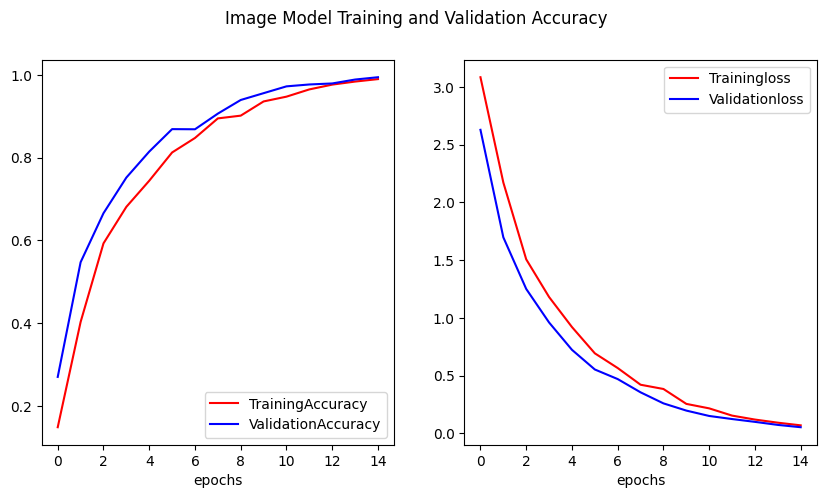

In [65]:
# Plotting results for image model
plot_training_results(history_image, 'Image Model Training and Validation Accuracy')

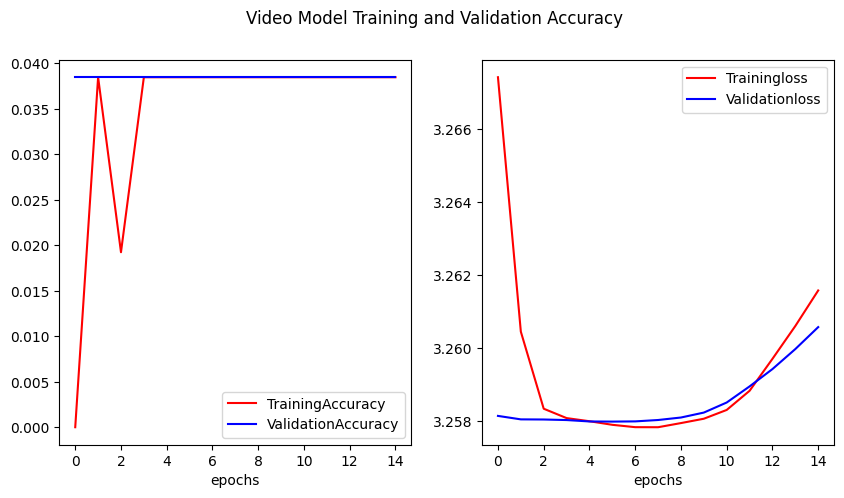

In [ ]:
# Plotting results for video model
plot_training_results(history_video, 'Video Model Training and Validation Accuracy')

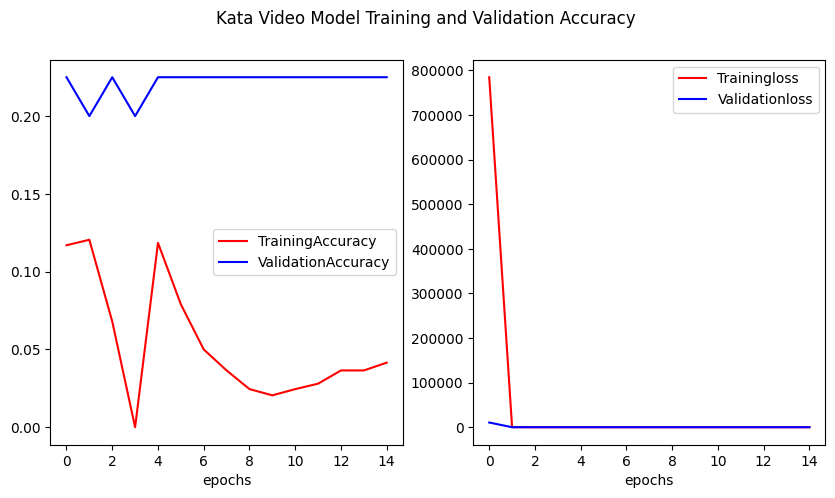

In [67]:
# Plotting results for kata video model
plot_training_results(history_kata_video, 'Kata Video Model Training and Validation Accuracy')

### Real-time gesture detection

In [6]:
# Define the model directory path where your trained model is saved
model_dir = '../models/'

# Load gesture model
gesture_model = tf.keras.models.load_model(os.path.join(model_dir, 'image_model.h5'))

# Class names for gesture recognition
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
               'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

In [ ]:
def detect_gestures(image):
    # Detect hand and body landmarks
    with mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.7) as hands, \
         mp_pose.Pose(static_image_mode=False, model_complexity=1, min_detection_confidence=0.7) as pose:

        hand_results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        pose_results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        gesture_text = ''

        # Draw hand landmarks
        if hand_results.multi_hand_landmarks:
            for hand_landmarks in hand_results.multi_hand_landmarks:
                mp.solutions.drawing_utils.draw_landmarks(
                    image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

                # Extract hand landmarks and make prediction
                hand_landmarks_np = np.array([[lm.x, lm.y] for lm in hand_landmarks.landmark])
                hand_landmarks_np = hand_landmarks_np.flatten().reshape(1, -1)

                if hand_landmarks_np.shape[1] == 42:  # Ensure the correct shape
                    prediction = gesture_model.predict(hand_landmarks_np)
                    class_idx = np.argmax(prediction)
                    gesture_text = class_names[class_idx]

        # Draw pose landmarks
        if pose_results.pose_landmarks:
            mp.solutions.drawing_utils.draw_landmarks(
                image, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        return image, gesture_text

In [3]:
def display_detection(image_path):
    image = cv2.imread(image_path)
    image, gesture_text = detect_gestures(image)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Gesture Detection: {gesture_text}')
    plt.axis('off')
    plt.show()

In [4]:
def real_time_gesture_detection():
    cap = cv2.VideoCapture(0)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Resize the frame to reduce processing time
        small_frame = cv2.resize(frame, (0, 0), fx=0.5, fy=0.5)
        frame_with_gestures, gesture_text = detect_gestures(small_frame.copy())

        # Resize back to original size for display purposes
        frame_with_gestures = cv2.resize(frame_with_gestures, (frame.shape[1], frame.shape[0]))

        # Add the gesture text to the frame with the subtitle included
        cv2.putText(frame_with_gestures, f'Gesture: {gesture_text}', (10, frame.shape[0] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Add subtitle at the top of the frame
        cv2.putText(frame_with_gestures, f'Subtitle: {gesture_text}', (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Display original frame and processed frame in separate windows
        cv2.imshow('Original Frame', frame)
        cv2.imshow('Processed Frame with Subtitle', frame_with_gestures)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [5]:
# Call the real-time gesture detection function
real_time_gesture_detection()

NameError: name 'cv2' is not defined